  0%|          | 0/1038 [00:00<?, ?it/s]

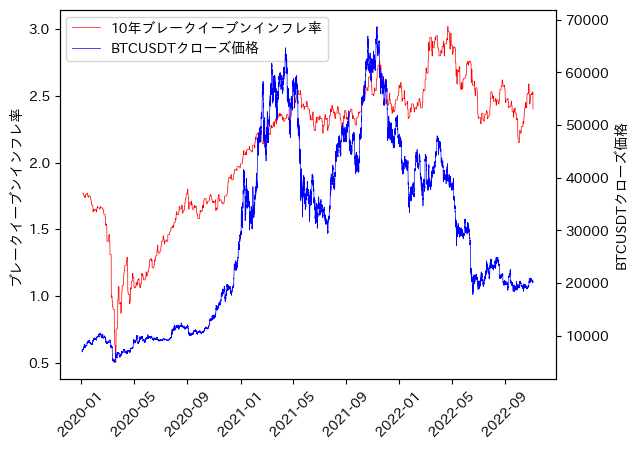

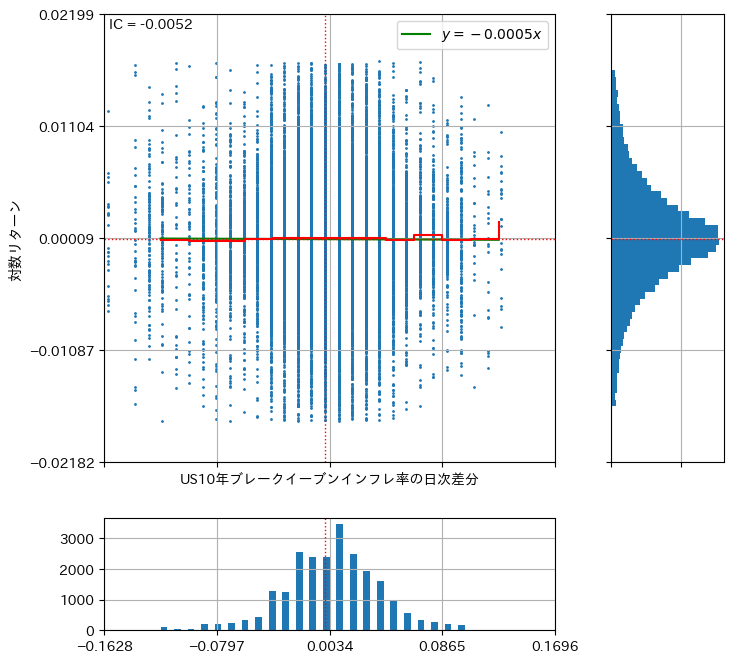

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.auto import tqdm
import talib
import exercise_util
import pandas_datareader.data as web

# 2020/1/1から今日までのブレークイーブンインフレ率をpandas_datareaderを使って読み込む
# このデータフレームは一行一日
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.now()
df_inflation = web.DataReader('T10YIE', 'fred', start, end)

# BTCUSDTの1時間足を読み込む
# このデータフレームは一行一時間
str_start = '2020-01-01'
_symbol = 'BTCUSDT'
df_timebar = exercise_util.concat_timebar_files(_symbol, 3600, str_start)

# ブレークイーブンインフレ率の差分系列を作る
df_inflation['T10YIE_diff'] = df_inflation['T10YIE'].diff()

# クローズ価格の対数リターンを求める
df_analysis = df_timebar.copy()
df_analysis['lr'] =  np.log(df_analysis['close']) - np.log(df_analysis['close'].shift(1))

# 一行一時間のdf_analysisと一行一日のdf_inflationを横方向に結合する
df_analysis = pd.concat([df_analysis, df_inflation], axis = 1)

# df_inflationは一行一日だったので23時間分がNaNで埋まっている。NaNをffillして全て埋める
df_analysis = df_analysis.ffill()

# インフレ率だけしかない行が残っているので削除する
df_analysis.dropna(inplace = True)

# FREDのブレークイーブンインフレ率はUTC21:00にアップデートされる。今のデータフレームはUTC00:00にアップデートされている状態なので、21時間ずらす
# T10YIEを1時間間隔にしてから差分を求めてしまうと、ほとんどの行で差分0になってしまって意図した動作にならない
df_analysis['T10YIE'] = df_analysis['T10YIE'].shift(21)
df_analysis['T10YIE_diff'] = df_analysis['T10YIE_diff'].shift(21)

# BTCUSDTの対数リターンが極端な値を取っている行を削除する
df_analysis = df_analysis[(df_analysis['lr'] > df_analysis['lr'].quantile(0.02)) & (df_analysis['lr'] < df_analysis['lr'].quantile(0.98))]

# 時間インデックスに基づいてソートし、相関を求めたい期間の行だけを抜き出す
df_analysis = df_analysis.sort_index()
df_analysis = df_analysis[df_analysis.index >= '2020-01-01']

# 時系列のプロット
fig, ax1 = plt.subplots() 
ax1.set_ylabel('ブレークイーブンインフレ率') 
ax1.tick_params(axis = 'x', labelrotation = 45)
line1 = ax1.plot(df_analysis['T10YIE'], color = 'red', lw = 0.5, label = '10年ブレークイーブンインフレ率') 
ax2 = ax1.twinx() 
ax2.set_ylabel('BTCUSDTクローズ価格') 
line2 = ax2.plot(df_analysis['close'], color = 'blue', lw = 0.5, label = 'BTCUSDTクローズ価格') 

# 2軸分の凡例をきれいに表示する
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc = 0)

fig.show()

# 分布図のプロット
exercise_util.show_correlation(df_analysis['T10YIE_diff'], df_analysis['lr'], xaxis_label = 'US10年ブレークイーブンインフレ率の日次差分', yaxis_label = '対数リターン', legend_loc = 'upper right')